In [2]:
import os
os.chdir('/app/Pogona_realtime/Arena')

In [3]:
import torch
import glob
import numpy as np
import imp
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import pickle
import seaborn as sns
import imp
from IPython.display import display, HTML
from sklearn.mixture import GaussianMixture
from scipy import stats
import json
import shutil
import random
import re
import math
from datetime import datetime

from Prediction import dataset
from Prediction import predictor
from Prediction import detector
from Prediction.detector import Detector_v4, Detector_v3
from Prediction import visualize
from Prediction import calibration as calib
from Prediction.kalman_predict import KalmanPredictor
from Prediction.predictor import HitPredictor
from Prediction.visualize import process_video, get_correction_fn, offline_predictor_visualizer
from Prediction import seq2seq_predict
from Prediction import train_eval

WEIGHTS_PATH = 'Prediction/Yolo4/yolo4_gs_best_2306.weights'
CFG_PATH = 'Prediction/Yolo4/yolo4_2306.cfg'

## Initialize YOLOv4 detector

In [2]:
det = Detector_v4()

Detector initiated successfully


## Mass update homography matrix

In [2]:
feeding_videos = list(map(lambda x: os.path.join(x, "1950648.avi"), glob.glob("../../Pogona_Pursuit/Arena/output/*feeding*")))

In [698]:
all_json_paths = glob.glob('../../Pogona_Pursuit/Arena/experiments/*/*/rt_data/vid_stats.json')

In [700]:
width=1440
for json_path in all_json_paths:
    with open(json_path, 'r') as f:
        d = json.load(f)
    d.pop('affine_mat')
    if d['width'] == width:
        d['homography'] = h_old.tolist()
    else:
        d['homography'] = None
    
    with open(json_path, 'w') as f:
        json.dump(d, f)

## Move all rt_data folders from previous location

In [44]:
rt_folders = glob.glob("../../Pogona_Pursuit/Arena/experiments/*/*/rt_data")

In [58]:
src_dest = list(map(lambda p: (p, glob.glob(os.path.join(os.path.split(p)[0], "videos","*"))[0]), rt_folders))

In [61]:
for src, dest in src_dest[1:]:
    print(src, dest)
    shutil.move(src, dest)

../../Pogona_Pursuit/Arena/experiments/line_20200803T081735/trial1/rt_data ../../Pogona_Pursuit/Arena/experiments/line_20200803T081735/trial1/videos/20200803-081735
../../Pogona_Pursuit/Arena/experiments/line_20200803T082002/trial1/rt_data ../../Pogona_Pursuit/Arena/experiments/line_20200803T082002/trial1/videos/20200803-082002
../../Pogona_Pursuit/Arena/experiments/fast_line_20200803T082414/trial1/rt_data ../../Pogona_Pursuit/Arena/experiments/fast_line_20200803T082414/trial1/videos/20200803-082414
../../Pogona_Pursuit/Arena/experiments/fast_line_20200803T082724/trial1/rt_data ../../Pogona_Pursuit/Arena/experiments/fast_line_20200803T082724/trial1/videos/20200803-082724
../../Pogona_Pursuit/Arena/experiments/circle_20200803T084227/trial1/rt_data ../../Pogona_Pursuit/Arena/experiments/circle_20200803T084227/trial1/videos/20200803-084228
../../Pogona_Pursuit/Arena/experiments/circle_20200803T084227/trial2/rt_data ../../Pogona_Pursuit/Arena/experiments/circle_20200803T084227/trial2/video

## Analyze single trial

In [4]:
dataset.analyze_rt_data('../../Pogona_Pursuit/Arena/output/feeding_4_20200830-125905', det)


Saved ../../Pogona_Pursuit/Arena/output/feeding_4_20200830-125905/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/output/feeding_4_20200830-125905/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/output/feeding_4_20200830-125905/rt_data/vid_stats.json


## Analyze new trials

In [ ]:
dataset.analyze_new_data(det)

Analyzing ../../Pogona_Pursuit/Arena/output/feeding_4_screen_20200830-130446:



Saved ../../Pogona_Pursuit/Arena/output/feeding_4_screen_20200830-130446/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/output/feeding_4_screen_20200830-130446/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/output/feeding_4_screen_20200830-130446/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/output/feeding_5_20200830-131348:



Saved ../../Pogona_Pursuit/Arena/output/feeding_5_20200830-131348/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/output/feeding_5_20200830-131348/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/output/feeding_5_20200830-131348/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/output/feeding_5_20200830-131916:
ERROR:
Some of the polygons are too close to each other.
Could not calibrate video at ../../Pogona_Pursuit/Arena/output/feeding_5_20200830-131916/19506468.avi



Saved ../../Pogona_Pursuit/Arena/output/feeding_5_20200830-131916/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/output/feeding_5_20200830-131916/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/output/feeding_5_20200830-131916/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/output/feeding3_20200902-113026:
ERROR:
Could not find 4 square marks in the image, only 3 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/output/feeding3_20200902-113026/19506468.avi



Saved ../../Pogona_Pursuit/Arena/output/feeding3_20200902-113026/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/output/feeding3_20200902-113026/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/output/feeding3_20200902-113026/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/output/feeding3_20200902-122338:
ERROR:
Could not find 4 square marks in the image, only 3 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/output/feeding3_20200902-122338/19506468.avi



Saved ../../Pogona_Pursuit/Arena/output/feeding3_20200902-122338/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/output/feeding3_20200902-122338/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/output/feeding3_20200902-122338/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/output/feeding3_20200902-122611:



Saved ../../Pogona_Pursuit/Arena/output/feeding3_20200902-122611/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/output/feeding3_20200902-122611/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/output/feeding3_20200902-122611/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/output/feeding3_20200902-142400:
ERROR:
Could not find 4 square marks in the image, only 1 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/output/feeding3_20200902-142400/19506468.avi



Saved ../../Pogona_Pursuit/Arena/output/feeding3_20200902-142400/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/output/feeding3_20200902-142400/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/output/feeding3_20200902-142400/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/output/feeding4_20200902-132659:
ERROR:
Could not find 4 square marks in the image, only 3 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/output/feeding4_20200902-132659/19506468.avi



Saved ../../Pogona_Pursuit/Arena/output/feeding4_20200902-132659/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/output/feeding4_20200902-132659/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/output/feeding4_20200902-132659/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/output/feeding4_20200902-132954:
ERROR:
Could not find 4 square marks in the image, only 2 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/output/feeding4_20200902-132954/19506468.avi



Saved ../../Pogona_Pursuit/Arena/output/feeding4_20200902-132954/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/output/feeding4_20200902-132954/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/output/feeding4_20200902-132954/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/output/feeding4_20200902-140215:
ERROR:
Could not find 4 square marks in the image, only 2 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/output/feeding4_20200902-140215/19506468.avi



Saved ../../Pogona_Pursuit/Arena/output/feeding4_20200902-140215/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/output/feeding4_20200902-140215/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/output/feeding4_20200902-140215/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/output/feeding4_20200902-140800:
ERROR:
Could not find 4 square marks in the image, only 3 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/output/feeding4_20200902-140800/19506468.avi



Saved ../../Pogona_Pursuit/Arena/output/feeding4_20200902-140800/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/output/feeding4_20200902-140800/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/output/feeding4_20200902-140800/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/output/feeding3_20200902-145846:
ERROR:
Could not find 4 square marks in the image, only 3 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/output/feeding3_20200902-145846/19506468.avi



Saved ../../Pogona_Pursuit/Arena/output/feeding3_20200902-145846/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/output/feeding3_20200902-145846/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/output/feeding3_20200902-145846/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial1/videos/20200727-080358:
ERROR:
Could not find 4 square marks in the image, only 0 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial1/videos/20200727-080358/19506468.avi



Saved ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial1/videos/20200727-080358/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial1/videos/20200727-080358/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial1/videos/20200727-080358/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial2/videos/20200727-081031:
ERROR:
Could not find 4 square marks in the image, only 0 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial2/videos/20200727-081031/19506468.avi



Saved ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial2/videos/20200727-081031/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial2/videos/20200727-081031/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial2/videos/20200727-081031/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial3/videos/20200727-081705:
ERROR:
Could not find 4 square marks in the image, only 0 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial3/videos/20200727-081705/19506468.avi



Saved ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial3/videos/20200727-081705/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial3/videos/20200727-081705/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial3/videos/20200727-081705/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial4/videos/20200727-082337:
ERROR:
Could not find 4 square marks in the image, only 0 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial4/videos/20200727-082337/19506468.avi



Saved ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial4/videos/20200727-082337/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial4/videos/20200727-082337/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial4/videos/20200727-082337/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/experiments/test_20200727T100404/trial1/videos/20200727-100404:
ERROR:
Could not find 4 square marks in the image, only 0 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/experiments/test_20200727T100404/trial1/videos/20200727-100404/19506468.avi



Saved ../../Pogona_Pursuit/Arena/experiments/test_20200727T100404/trial1/videos/20200727-100404/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/experiments/test_20200727T100404/trial1/videos/20200727-100404/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/experiments/test_20200727T100404/trial1/videos/20200727-100404/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/experiments/cockroach_20200729T084031/trial1/videos/20200729-084032:
ERROR:
Could not find 4 square marks in the image, only 0 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/experiments/cockroach_20200729T084031/trial1/videos/20200729-084032/19506468.avi



Saved ../../Pogona_Pursuit/Arena/experiments/cockroach_20200729T084031/trial1/videos/20200729-084032/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/experiments/cockroach_20200729T084031/trial1/videos/20200729-084032/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/experiments/cockroach_20200729T084031/trial1/videos/20200729-084032/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/experiments/cockroach_20200729T084031/trial2/videos/20200729-084703:
ERROR:
Could not find 4 square marks in the image, only 0 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/experiments/cockroach_20200729T084031/trial2/videos/20200729-084703/19506468.avi



Saved ../../Pogona_Pursuit/Arena/experiments/cockroach_20200729T084031/trial2/videos/20200729-084703/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/experiments/cockroach_20200729T084031/trial2/videos/20200729-084703/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/experiments/cockroach_20200729T084031/trial2/videos/20200729-084703/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/experiments/worm_20200729T090421/trial1/videos/20200729-090421:
ERROR:
Could not find 4 square marks in the image, only 0 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/experiments/worm_20200729T090421/trial1/videos/20200729-090421/19506468.avi



Saved ../../Pogona_Pursuit/Arena/experiments/worm_20200729T090421/trial1/videos/20200729-090421/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/experiments/worm_20200729T090421/trial1/videos/20200729-090421/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/experiments/worm_20200729T090421/trial1/videos/20200729-090421/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/experiments/worm_20200729T103122/trial2/videos/20200729-103756:
ERROR:
Could not find 4 square marks in the image, only 0 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/experiments/worm_20200729T103122/trial2/videos/20200729-103756/19506468.avi



Saved ../../Pogona_Pursuit/Arena/experiments/worm_20200729T103122/trial2/videos/20200729-103756/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/experiments/worm_20200729T103122/trial2/videos/20200729-103756/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/experiments/worm_20200729T103122/trial2/videos/20200729-103756/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/experiments/worm_20200729T103122/trial3/videos/20200729-104429:
ERROR:
Could not find 4 square marks in the image, only 0 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/experiments/worm_20200729T103122/trial3/videos/20200729-104429/19506468.avi



Saved ../../Pogona_Pursuit/Arena/experiments/worm_20200729T103122/trial3/videos/20200729-104429/rt_data/detections.csv
 ../../Pogona_Pursuit/Arena/experiments/worm_20200729T103122/trial3/videos/20200729-104429/rt_data/head_crops.p
 ../../Pogona_Pursuit/Arena/experiments/worm_20200729T103122/trial3/videos/20200729-104429/rt_data/vid_stats.json
Analyzing ../../Pogona_Pursuit/Arena/experiments/fast_cockroach_20200729T105342/trial1/videos/20200729-105345:
ERROR:
Could not find 4 square marks in the image, only 0 found.
Could not calibrate video at ../../Pogona_Pursuit/Arena/experiments/fast_cockroach_20200729T105342/trial1/videos/20200729-105345/19506468.avi


found with brightness: 0, contrast: 3.0


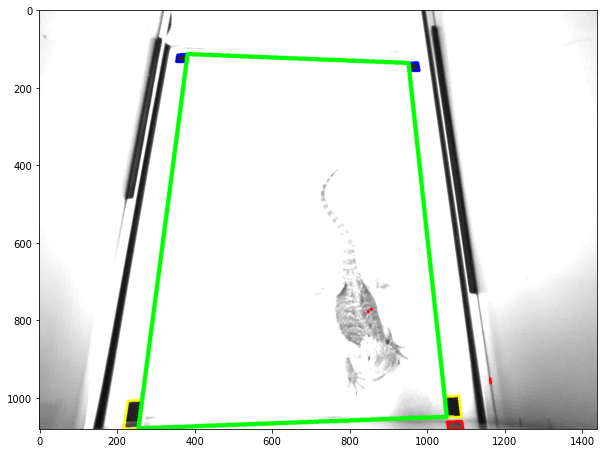

In [7]:
# problematic video (reflection is added to sticker):
# "../../Pogona_Pursuit/Arena/output/feeding3_20200902-122338/19506468.avi"
# "../../Pogona_Pursuit/Arena/output/feeding3_20200902-122611/19506468.avi"
vcap = cv.VideoCapture("../../Pogona_Pursuit/Arena/output/feeding3_20200902-122338/19506468.avi")
h, h_im = dataset.get_homography_from_video(vcap, undist_alpha=0)
#h, h_im = dataset.get_homography_from_video(vcap, undist_alpha=0.3, min_near_edge_size=20)
plt.figure(figsize=(10,15))
plt.imshow(h_im)
#plt.imshow(calib.transform_image(h_im, h))

## Analyze videos with custom undistortion alpha
This was necessary when the markings were too close to the edge of the camera frame, but produced some bad results.

In [96]:
paths = [
    "../../Pogona_Pursuit/Arena/experiments/cockroach_20200907T152020/trial1/videos/20200907-152021",
    "../../Pogona_Pursuit/Arena/experiments/cockroach_20200907T152020/trial2/videos/20200907-152653",
    "../../Pogona_Pursuit/Arena/experiments/cockroach_20200907T152020/trial3/videos/20200907-153326",
    "../../Pogona_Pursuit/Arena/experiments/cockroach_20200907T145302/trial1/videos/20200907-145302",
    "../../Pogona_Pursuit/Arena/experiments/cockroach_20200907T145302/trial2/videos/20200907-145935",
    "../../Pogona_Pursuit/Arena/experiments/cockroach_20200907T145302/trial3/videos/20200907-150607",
    "../../Pogona_Pursuit/Arena/experiments/circle_20200907T145105/trial1/videos/20200907-145106",
]

In [105]:
for path in paths:
    print(path)
    #dataset.analyze_rt_data(path, det, undist_alpha=0.3, homography_args={"min_near_edge_size": 20})
    #dataset.save_homography_data(path)
    dataset.save_homography_data(path, undist_alpha=0.3, homography_args={"min_near_edge_size": 20})

../../Pogona_Pursuit/Arena/experiments/cockroach_20200907T152020/trial1/videos/20200907-152021
Could not find homography: Could not find 2 far and 2 near square marks in the image.
../../Pogona_Pursuit/Arena/experiments/cockroach_20200907T152020/trial2/videos/20200907-152653


KeyboardInterrupt: 

# Data collection into a pandas DataFrame

In [2]:
df = dataset.collect_data(data_sources={'detections': True, 'timestamps': True, 'dlc': False, 'touches': True})

47 trials loaded


In [ ]:
df.head()

In [8]:
feeding_data = df.filter(like='feeding',axis=0)

(-316.44971621769344,
 2454.0077225712816,
 -210.37253190773956,
 3411.8167634074675)

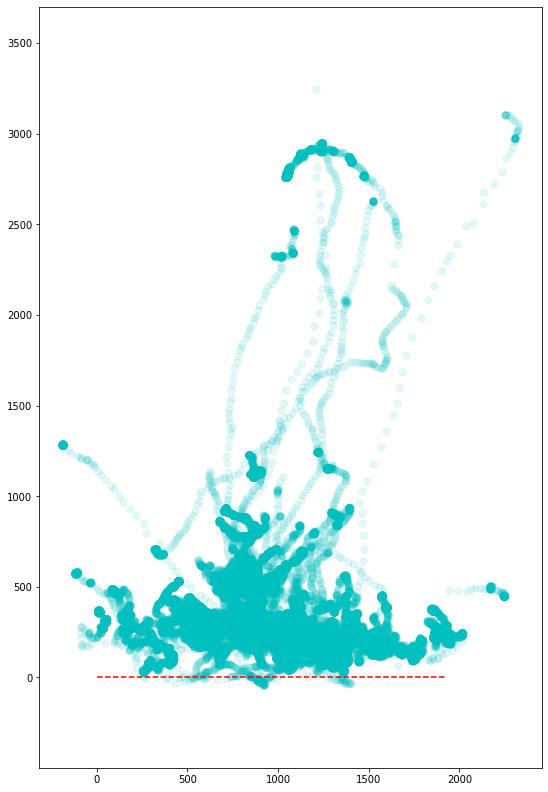

In [9]:
plt.figure(figsize=(9,14))
feeding = df.index.str.contains('feeding') & ~df.index.str.contains('feeding3_20200902-142400_None')
experi =  ~df.index.str.contains('feeding')
#plt.scatter(df[~mask].x2, df[~mask].y2, color='g' ,alpha=0.02)
plt.scatter(df[experi].cent_x, df[experi].cent_y, color='c' ,alpha=0.1,s=50,zorder=2)

#plt.plot(df[mask].x2, df[mask].y2, color='k' ,alpha=0.6,zorder=0)

#trial = np.random.choice(df.index.unique())
#plt.plot(df.loc[trial].x2, df.loc[trial].y2, color='k' ,alpha=0.9,zorder=0)


#sns.jointplot(df.x2, df.y2, kind='hex',)
plt.plot(np.linspace(0,1920,num=10),np.zeros(10),color='r',linestyle='--')
plt.axis('equal')

# Aruco calibration

In [9]:
aruco_paths = glob.glob(os.path.join(dataset.OUTPUT_ROOT,'aruco_test_final*'))
rt_aruco_vids = [os.path.join(p,'19506468.avi') for p in aruco_paths]

In [53]:
for aruco_vid in rt_aruco_vids:
    fname = os.path.split(os.path.split(aruco_vid)[0])[1]
    print(fname)
    visualize.process_video(video_path=aruco_vid,
                            output_path=None,
                           process_fns=[visualize.video_sampler('../aruco_frames/',100,fname)])

aruco_test_final_20200909-175108


## Test the online prediction pipeline

In [3]:
weights_path_encdec = 'Prediction/traj_models/model_20_20_h64_b64_l1_EncDec_6_best.pth'
weights_path_lstmdense = 'Prediction/traj_models/model_20_20_h64_b128_l1_lstmDense_feeding_51_best.pth'
traj_model_encdec = seq2seq_predict.GRUEncDec()
traj_model_lstmdense = seq2seq_predict.LSTMdense(output_seq_size=20,hidden_size=64,LSTM_layers=1, embedding_size=16)
history_len = 20
forecast_horizon = 20

traj_gru = seq2seq_predict.Seq2SeqPredictor(model=traj_model_encdec, 
                                            weights_path=weights_path_encdec,
                                           history_len=history_len, forecast_horizon=forecast_horizon)

traj_lstm = seq2seq_predict.Seq2SeqPredictor(model = traj_model_lstmdense,
                                            weights_path=weights_path_lstmdense,
                                            history_len=history_len,
                                            forecast_horizon=forecast_horizon)

In [4]:
hit_pred = predictor.HitPredictor(trajectory_predictor=traj_lstm,detector=det)

In [5]:
mapping, _, newcammat = calib.get_undistort_mapping(1440,1080)

In [6]:
aruco_img_paths = glob.glob(os.path.join('../aruco_frames','aruco_test_final*'))

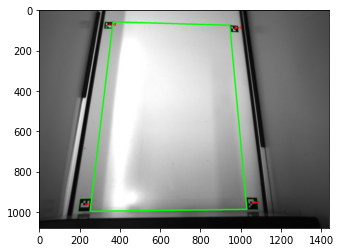

In [30]:
# Creates a new homography file in Arena/calibration
# NOT NECESSARY FOR OTHER TESTS
img = cv.imread(aruco_img_paths[0])
h, h_img, error = hit_pred.calibrate(img)
plt.imshow(h_img)

In [512]:
pog = cv.imread("../pogona_frames/pogona800.jpg")

In [9]:
hit_pred.reset()
for i in range(hit_pred.trajectory_predictor.forecast_horizon):
    print(f"{i}: {hit_pred.handle_frame(pog)}")

0: (None, None, None)
1: (None, None, None)
2: (None, None, None)
3: (None, None, None)
4: (None, None, None)
5: (None, None, None)
6: (None, None, None)
7: (None, None, None)
8: (None, None, None)
9: (None, None, None)
10: (None, None, None)
11: (None, None, None)
12: (None, None, None)
13: (None, None, None)
14: (None, None, None)
15: (None, None, None)
16: (None, None, None)
17: (None, None, None)
18: (None, None, None)
19: (array([[3122.69373647, 3148.02713407, 3122.20493337, 3147.39071479],
       [3122.76229161, 3147.97080788, 3122.43544183, 3147.27285536],
       [3122.78917997, 3148.08124551, 3122.33247127, 3147.31574386],
       [3122.62195282, 3148.05946001, 3122.21989298, 3147.19992201],
       [3122.76374228, 3148.09654173, 3122.26252633, 3147.24496956],
       [3122.68543736, 3148.08375768, 3122.30612003, 3147.18710007],
       [3122.78892687, 3148.0980842 , 3122.34272609, 3147.25048886],
       [3122.71301869, 3148.05018932, 3122.37566055, 3147.28909251],
       [3122.823

# Test HitPredictor with None detections
currently, if there was a frame with no detections the trajectory predictor will return a nan array for as long as this frame is in the history window.

We should probably change this to something smarter.

In [28]:
hit_pred.reset()
detection = hit_pred.detect_pogona_head(pog)
for i in range(hit_pred.trajectory_predictor.forecast_horizon):
    det = detection if random.random() > 0.3 else None
    pred = hit_pred.handle_detection(det)
    print(f"{i}: {pred}, detection: {det}, history_len: {hit_pred.frame_num}")

0: (None, None, None), detection: None, history_len: 1
1: (None, None, None), detection: [3122.64520503 3147.87613856 3122.25926891 3147.52489982], history_len: 2
2: (None, None, None), detection: None, history_len: 3
3: (None, None, None), detection: [3122.64520503 3147.87613856 3122.25926891 3147.52489982], history_len: 4
4: (None, None, None), detection: [3122.64520503 3147.87613856 3122.25926891 3147.52489982], history_len: 5
5: (None, None, None), detection: [3122.64520503 3147.87613856 3122.25926891 3147.52489982], history_len: 6
6: (None, None, None), detection: [3122.64520503 3147.87613856 3122.25926891 3147.52489982], history_len: 7
7: (None, None, None), detection: [3122.64520503 3147.87613856 3122.25926891 3147.52489982], history_len: 8
8: (None, None, None), detection: None, history_len: 9
9: (None, None, None), detection: [3122.64520503 3147.87613856 3122.25926891 3147.52489982], history_len: 10
10: (None, None, None), detection: None, history_len: 11
11: (None, None, None

## Test HitPredictor with offline data around hit

**TODO**: work with actual hit trajectories

In [29]:
df_hits = df[df.hit]
len(df_hits)

40

In [60]:
hits = df_hits[['x1', 'y1', 'x2', 'y2']].values
hits[:,3]

array([ 6.51758332e+01, -4.07620613e-02,  1.14869626e+03, -2.87025477e+01,
        6.80194841e+01,  1.63921977e+01, -7.29470282e+00, -3.25651216e+01,
       -4.16713824e+01, -7.98899904e+00,  5.70554538e+00, -1.42326247e+01,
        6.61659971e+00,  8.35271669e+00, -6.27711638e+00,  8.71258571e+00,
        8.88384712e+00,  6.95714429e+00,  1.93783809e+01,  6.02640772e+00,
       -5.33735637e+01, -5.40618905e+01, -2.71960426e+01,  4.50226163e+01,
       -2.54974718e+01, -3.61470292e+01,  5.44290646e+00,  2.38841003e+01,
       -3.11376783e+01, -4.61410016e+01, -7.96339896e+00, -4.13322990e+00,
       -4.15946079e+01,  5.45529999e+00,  1.17630754e+02,  3.82260420e+01,
        3.43020806e+02, -8.77525925e+01,  2.30602582e+01,  2.52667315e+02])

In [61]:
hit_pred.reset()
det = hits[1]
for i in range(hit_pred.trajectory_predictor.forecast_horizon):
    pred = hit_pred.handle_detection(det)
forecast = pred[0]

In [69]:
pred[0].astype(np.int)

array([[  48,  338, -217,    0],
       [  48,  338, -217,    0],
       [  49,  339, -217,    0],
       [  48,  339, -217,    0],
       [  49,  339, -217,    0],
       [  48,  339, -217,    0],
       [  49,  339, -217,    0],
       [  48,  339, -217,    0],
       [  49,  338, -217,    0],
       [  48,  338, -217,    0],
       [  48,  338, -217,    0],
       [  48,  338, -217,    0],
       [  49,  338, -217,    0],
       [  48,  338, -217,    0],
       [  48,  338, -217,    0],
       [  49,  339, -217,    0],
       [  48,  338, -217,    0],
       [  48,  338, -217,    0],
       [  48,  338, -217,    0],
       [  48,  338, -217,    0]])

In [71]:
pred[1:]

(-84.16365967550364, 0)

In [57]:
forecast[:,2]

array([-16.82229961, -16.59179115, -16.69476171, -16.80734   ,
       -16.76470664, -16.72111295, -16.68450689, -16.65157243,
       -16.75234525, -16.77400959, -16.60730231, -16.71133719,
       -16.73428593, -16.81634923, -16.6956466 , -16.82698819,
       -16.88331274, -16.87866658, -16.89303418, -16.83918629])

In [48]:
def get_date_from_path(path):
    date_rgx = r'\d{8}-\d{6}'
    to_search = os.path.split(path)[-1]
    date_str = re.findall(date_rgx, to_search)[-1]
    print(date_str)
    return pd.to_datetime(date_str)

# Pogona_Pursuit/Arena/experiments/cockroach_20200907T152020/trial1/videos/20200907-152021
# Pogona_Pursuit/Arena/output/aruco_test_final_20200909-175108
def find_last_homography(path):
    video_date = get_date_from_path(path)
    calibration_paths = glob.glob(CALIBRATIONS_ROOT+'*')
    calibration_dates = pd.Series([get_date_from_path(calib_path) for calib_path in calibration_paths])
    tiled_video_date = pd.Series([video_date] * calibration_dates.shape[0])
    date_diffs = tiled_video_date - calibration_dates
    last_date = (date_diffs[date_diffs >= pd.Timedelta(0)]).argmin()
    last_calib_path = calibration_paths[last_date]
    
    with open(last_calib_path, 'r') as fp:
        homog_dict = json.load(fp)
    
    return np.array(homog_dict['homography'])

In [49]:
path_exp = 'Pogona_Pursuit/Arena/experiments/cockroach_20200907T152020/trial1/videos/20200907-152021'
path_out = 'Pogona_Pursuit/Arena/output/aruco_20200919-175108_20200909-175128_test_final_20200909-175108'
calib_path1 = 'Pogona_Pursuit/Arena/calibration/homog_20200902-170900.json'
calib_path2 = 'Pogona_Pursuit/Arena/calibration/homog_20200903-170901.json'
calib_path3 = 'Pogona_Pursuit/Arena/calibration/homog_20200911-170901.json'

In [52]:
get_date_from_path(calib_path1)

20200902-170900


Timestamp('2020-09-02 17:09:00')

In [65]:
temp = pd.DataFrame({'A':np.arange(5),'B':np.arange(5),'D':np.arange(5)})

In [66]:
temp.insert(loc=len(temp.columns)-1,column='C',value=[True]*temp.shape[0])

## Convolutional croppd head encoder tests

In [149]:
imp.reload(seq2seq_predict)

<module 'Prediction.seq2seq_predict' from '/app/Pogona_realtime/Arena/Prediction/seq2seq_predict.py'>

In [10]:
c = seq2seq_predict.ConvEncoder(32,32,5,4,10)

In [6]:
diffs = torch.rand(2,20,4)

In [7]:
head_seq = torch.rand(2,20,32,32)

In [8]:
head_input = head_seq.unsqueeze(2).reshape(-1, 1, head_seq.size(-2), head_seq.size(-1))

In [11]:
head_embedding = c(head_input)

In [12]:
head_embedding = head_embedding.reshape(2, 20, -1)

In [13]:
torch.cat([diffs, head_embedding], dim=2).size()

torch.Size([2, 20, 9])

In [14]:
net = seq2seq_predict.GRUEncDecWithHead()

In [15]:
net(diffs, head_seq).size()

torch.Size([2, 20, 4])

In [16]:
x = torch.rand(1,1,32,32)

In [18]:
net.head_embedder.conv1(x).size()

torch.Size([1, 4, 30, 30])

## Cropped Head images dataset and dataloader

Detections data pipeline:
- detections.csv -> distortion and homography -> unified dataframe -> pytorch iterable dataset ->
- split each trial to sequences in trial_to_samples (skips sequences with nan - original indexing breaks) ->
- create train and test dataloaders, that returns shuffeled batches of sequences.

Issues with cropped head files:
- Memory issues: in contrast to detections data, not possible to load entire cropped heads data, from hundreds of trials, to memory.
- Distorted and not transformed - we can pass on the distortion, but the homography is important. Maybe only rotate
- Resizing and arranging in PyTorch tensors - possibly the easiest way.
- None entries, aligining with detections indices.
- Currently in a single pickle file, alternative is saving in different 

Options of arranging cropped head data and join on detections data: 
New dataset structure, options. currently, TrajectoriesData dataset has 3D tensors - (# sequence, # index in sequence, # xyxy): 
* __Images in memory__: It's possible to create a new dataset subclass, where it's passed X,Y and another 4d tensor, "X_Images". This tensor could be created by the trial_to_samples function. __Main problem: a single detection's image could be in at most 20 different sequences, thus duplicating the image in memory. Will probably get too heavy, even if the original data is in realtively reasonable size__
* __Paths and alternative \_\_getitem\_\_ implementation__: each single sequence will have an array of paths for the images in that sequence, that will be returned by trial_to_samples. If X is a 3d tensor, then X_paths is a 2D tensor, each row containing either None or the path for the file. In each call to getitem, iterate over the paths and build a 3d tensor, an array of 2d images. Need to save in different files to work. It seems that's the way to do it... "One way of handling this is to split the file into a bunch of smaller files each containing one line of the original, then maintain a list of the paths of these small files and in _getitem_ read the file corresponding to the specified index. _This is how people mostly work with image data, where they have a bunch of images located in a directory_" from https://medium.com/swlh/how-to-use-pytorch-dataloaders-to-work-with-enormously-large-text-files-bbd672e955a0. Also here: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

* Alternatively, we could create new files for each trial, seperate from the dataframe - that natively include both the detections data and the image data, thus making it easier to organize the indices.

* __IterableDataset__: The defualt utils.dataset is a Map Dataset, which supports in memory structures with indexing (or some getitem implementation like the "paths" one). The IterableDataset is supposed to work with data streams (databases, remote servers, very large files, etc.). Doesn't seem to fit our case, becuase we need to 



__Required code changes for small amount of data (without reformatting entire data):__
* Write function to trnasform a list of uneven images to a 3d tensor.
* In trial_to_samples, accept a tensor of images of trial to jointly create a tuple of detections sequences tensor and image sequences tensor
* In TrajectoriesDataset, add images sequences tensor, where getitem returns a sequence of images along with the detections.
* In train_eval function, change to get image tensor and pass it to a network.

In [36]:
imp.reload(train_eval)
imp.reload(dataset)

<module 'Prediction.dataset' from '/app/Pogona_realtime/Arena/Prediction/dataset.py'>

In [37]:
df = dataset.collect_data(data_sources={'detections': True, 'timestamps': True, 'dlc': False, 'touches': True})

46 trials loaded


In [46]:
all_paths = dataset.select_paths(data_sources={'detections': True, 'timestamps': True, 'dlc': False, 'touches': True})

In [39]:
def get_rot_angle(homography):
    return - math.atan2(homography[0,1], homography[0,0]) * 180 / math.pi

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LANCZOS4)
    return result

In [38]:
def get_trial_data_with_heads_that_are_rotated(trial_tuple):
    trial_p = glob.glob(os.path.split(all_paths[trial_tuple]['detections'])[0]+'/*.p')[0]

    with open(all_paths[trial_tuple]['vid_stats'], 'r') as fp:
        vid_stats = json.load(fp)
    
    if vid_stats['homography'] is None:
        with open(dataset.DEFAULT_HOMOGRAPHY_JSON, 'r') as fp:
            h = np.array(json.load(fp)['new_h'])
    else:
        h = np.array(vid_stats['homography']) 
    rot_angle = get_rot_angle(h)

    with open(trial_p, 'rb') as fp:
        head_list = pickle.load(fp)
    
    rotated_head_list = [rotate_image(255-im, rot_angle) if im is not None else None for im in head_list]
    trial_df = df.loc["_".join((trial_tuple[0], str(trial_tuple[1])))]
    
    return trial_df, rotated_head_list

In [40]:
all_trials = df.index.unique()

In [41]:
train, val, test = train_eval.create_train_val_test_splits(all_trials, [0.8, 0.2, 0])

In [42]:
train, val, test

(['circle_20200803T121730_trial1',
  'worm_circle_20200830T122241_trial1',
  'cockroach_line_20200830T115811_trial1',
  'worm_line_20200830T122932_trial1',
  'beetle_fast_line_20200830T124020_trial1',
  'circle_20200803T092248_trial1',
  'fast_cockroach_20200803T085738_trial1',
  'circle_20200803T115839_trial1',
  'circle_20200803T090234_trial1',
  'line_20200803T095401_trial1',
  'circle_20200803T084529_trial1',
  'feeding_4_20200830-125905_None',
  'feeding_4_20200830-122515_None',
  'circle_20200803T113121_trial1',
  'line_20200803T081735_trial1',
  'red_beetle_20200826T133947_trial1',
  'line_20200803T122506_trial1',
  'feeding_5_20200830-131348_None',
  'worm_line_20200830T120451_trial1',
  'feeding_20200830-115520_None',
  'worm_20200826T134603_trial1',
  'worm_20200826T135440_trial1',
  'worm_line_20200830T121825_trial1',
  'circle_20200803T120911_trial1',
  'circle_20200803T084529_trial2',
  'circle_20200803T084227_trial2',
  'line_20200803T101641_trial1',
  'line_20200803T1149

In [43]:
import random

In [44]:
def get_size(tensor):
    return torch.prod(torch.tensor(tensor.size())).item()*4/(2**20)

In [904]:
print(f'test: {get_size(X_images_test)} , train: {get_size(X_images_train)}')

test: 730.390625 , train: 1452.421875


In [67]:
input_labels = ['x1', 'y1', 'x2', 'y2']
output_labels = ['x1', 'y1', 'x2', 'y2']
input_dim = len(input_labels)
output_dim = len(output_labels)

inp_seq_len = 20
out_seq_len = 20
embedding_size = 4  # only used in supporting models.
hidden_size = 300
rnn_layers = 1
dropout = 0.2
batch_size = 128

# train, test
len_list = [4,2]

X_coords_list = [[],[]]

X_images_list = [[],[]]

Y_list = [[],[]]

for i, trials in enumerate([train, val]):
    random.shuffle(trials)
    for trial in trials[:len_list[i]]:
        spl = trial.split('_')
        if spl[-1] == 'None':
            spl[-1] = None
        trial_tup = ('_'.join(spl[:-1]), spl[-1])
        print(trial_tup)
        df_trial, heads = get_trial_data_with_heads_that_are_rotated(trial_tup)

        (X_coords, X_images), Y = train_eval.trial_to_samples(df_trial, input_labels, output_labels, inp_seq_len, out_seq_len, 5, input_images=heads)
        X_coords_list[i].append(X_coords)
        X_images_list[i].append(X_images.float())
        Y_list[i].append(Y)       

        
X_coords_train = torch.cat(X_coords_list[0])
X_coords_test = torch.cat(X_coords_list[1])
X_images_train = torch.cat(X_images_list[0])
X_images_test = torch.cat(X_images_list[1])
Y_train = torch.cat(Y_list[0])
Y_test = torch.cat(Y_list[1])

dataset_train_wh = train_eval.TrajectoriesDataWithHeads(X_coords_train, X_images_train, Y_train)
dataset_test_wh = train_eval.TrajectoriesDataWithHeads(X_coords_test, X_images_test, Y_test)
dataset_train = train_eval.TrajectoriesData(X_coords_train, Y_train)
dataset_test = train_eval.TrajectoriesData(X_coords_test, Y_test)


dl_train_wh = torch.utils.data.DataLoader(dataset_train_wh, batch_size=batch_size, shuffle=True, num_workers=0)
dl_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
dl_test_wh = torch.utils.data.DataLoader(dataset_test_wh, batch_size=batch_size, shuffle=True, num_workers=0)
dl_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)

('line_20200803T082002', 'trial1')
('worm_circle_20200830T122241', 'trial1')
('line_20200803T122506', 'trial1')
('circle_20200803T084529', 'trial1')
('cockroach_circle_20200830T123508', 'trial1')
('feeding_4_20200830-125531', None)


In [80]:
net_wh = seq2seq_predict.GRUEncDecWithHead(output_seq_size=out_seq_len, hidden_size=hidden_size, GRU_layers=rnn_layers,
                                       dropout=dropout,head_embedder=seq2seq_predict.ConvEncoder(32, 32, 32, 2, 5))

In [81]:
model_type = "GRUEncDecWithHead"
date = datetime.now().strftime('%m%d-%H%M')
model_name=f"{model_type}_{date}_i{inp_seq_len}_o{out_seq_len}_h{hidden_size}_b{batch_size}_l{rnn_layers}"

clip_grad_norm = 1.5
lr = 0.0001
epochs = 100
eval_freq = 5
epoch_print_freq = 5
save_each_eval_model = False

best_epoch, best_ADE, losses, ADEs, FDEs = train_eval.train_trajectory_model(model=net_wh, 
                                                                             train_dataloader=dl_train_wh,
                                                                             test_dataloader=dl_test_wh,
                                                                             epochs=epochs,
                                                                             path='Prediction/traj_models/',
                                                                             clip_grad_norm=clip_grad_norm,
                                                                             eval_freq=eval_freq,
                                                                             epoch_print_freq=epoch_print_freq,
                                                                             model_name=model_name,
                                                                             save_each_eval_model=save_each_eval_model,
                                                                             lr=lr)

### Eval epoch: 0, Test set mean ADE: 94.995, mean FDE: 199.323
Epoch: 0, avg loss: 41.631, epoch time: 1.424
### Eval epoch: 5, Test set mean ADE: 48.643, mean FDE: 88.435
Epoch: 5, avg loss: 13.848, epoch time: 1.418
### Eval epoch: 10, Test set mean ADE: 48.237, mean FDE: 88.262
Epoch: 10, avg loss: 13.047, epoch time: 1.449
### Eval epoch: 15, Test set mean ADE: 47.481, mean FDE: 86.605
Epoch: 15, avg loss: 12.676, epoch time: 1.445
### Eval epoch: 20, Test set mean ADE: 48.128, mean FDE: 87.354
Epoch: 20, avg loss: 12.304, epoch time: 1.432
### Eval epoch: 25, Test set mean ADE: 48.951, mean FDE: 88.737
Epoch: 25, avg loss: 11.990, epoch time: 1.433
### Eval epoch: 30, Test set mean ADE: 49.572, mean FDE: 89.774
Epoch: 30, avg loss: 11.673, epoch time: 1.460
### Eval epoch: 35, Test set mean ADE: 50.297, mean FDE: 91.230
Epoch: 35, avg loss: 11.366, epoch time: 1.437
### Eval epoch: 40, Test set mean ADE: 51.862, mean FDE: 94.242
Epoch: 40, avg loss: 11.252, epoch time: 1.430
### 

KeyboardInterrupt: 

In [841]:
val

['circle_20200803T120911_trial1',
 'feeding_4_20200830-125905_None',
 'line_20200803T101641_trial1',
 'beetle_fast_line_20200830T124020_trial1',
 'line_20200803T095401_trial1',
 'feeding_20200830-120813_None',
 'circle_20200803T092248_trial1',
 'worm_circle_20200830T122241_trial1',
 'feeding_5_20200830-131916_None']

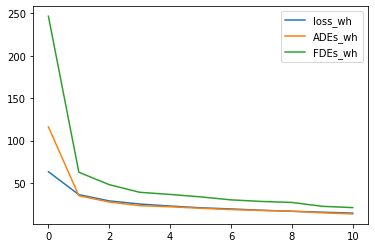

In [839]:
plt.plot([loss for i, loss in enumerate(losses) if i%5==0], label='loss_wh')
plt.plot(list(ADEs.values()), label='ADEs_wh')
plt.plot(list(FDEs.values()), label='FDEs_wh')
plt.legend()

In [79]:
net = seq2seq_predict.GRUEncDec(output_seq_size=out_seq_len, hidden_size=hidden_size, GRU_layers=rnn_layers,
                                       dropout=dropout)

model_type = "GRUEncDec"
date = datetime.now().strftime('%m%d-%H%M')
model_name=f"{model_type}_{date}_i{inp_seq_len}_o{out_seq_len}_h{hidden_size}_b{batch_size}_l{rnn_layers}"

#clip_grad_norm = 1.5
#lr = 0.001
#epochs = 51
#eval_freq = 5
#epoch_print_freq = 5
#save_each_eval_model = False

best_epoch, best_ADE, losses2, ADEs2, FDEs2 = train_eval.train_trajectory_model(model=net, 
                                                                             train_dataloader=dl_train,
                                                                             test_dataloader=dl_test,
                                                                             epochs=epochs,
                                                                             path='Prediction/traj_models/',
                                                                             clip_grad_norm=clip_grad_norm,
                                                                             eval_freq=eval_freq,
                                                                             epoch_print_freq=epoch_print_freq,
                                                                             model_name=model_name,
                                                                             save_each_eval_model=save_each_eval_model,
                                                                             lr=lr)


### Eval epoch: 0, Test set mean ADE: 92.086, mean FDE: 188.239
Epoch: 0, avg loss: 40.548, epoch time: 1.148
### Eval epoch: 5, Test set mean ADE: 48.480, mean FDE: 88.127
Epoch: 5, avg loss: 13.807, epoch time: 1.126
### Eval epoch: 10, Test set mean ADE: 48.370, mean FDE: 88.175
Epoch: 10, avg loss: 13.022, epoch time: 1.111
### Eval epoch: 15, Test set mean ADE: 47.835, mean FDE: 87.268
Epoch: 15, avg loss: 12.611, epoch time: 1.161
### Eval epoch: 20, Test set mean ADE: 47.772, mean FDE: 86.815
Epoch: 20, avg loss: 12.403, epoch time: 1.116
### Eval epoch: 25, Test set mean ADE: 47.653, mean FDE: 86.576
Epoch: 25, avg loss: 12.160, epoch time: 1.153
### Eval epoch: 30, Test set mean ADE: 47.774, mean FDE: 86.544
Epoch: 30, avg loss: 12.011, epoch time: 1.127
### Eval epoch: 35, Test set mean ADE: 48.537, mean FDE: 87.640
Epoch: 35, avg loss: 11.828, epoch time: 1.117
### Eval epoch: 40, Test set mean ADE: 48.493, mean FDE: 87.467
Epoch: 40, avg loss: 11.696, epoch time: 1.136
### 

KeyboardInterrupt: 

In [49]:
im_test = X_images_test[np.random.randint(X_images_test.shape[0]),np.random.randint(X_images_test.shape[1])]

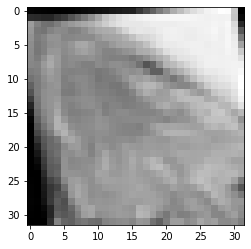

In [50]:
plt.imshow(im_test.numpy(),cmap='Greys_r')

In [51]:
net_wh.to('cuda')

GRUEncDecWithHead(
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (encoderGRU): GRU(6, 300, batch_first=True)
  (decoderGRU): GRUCell(4, 300)
  (linear): Linear(in_features=300, out_features=4, bias=True)
  (head_embedder): ConvEncoder(
    (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(4, 10, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc): Linear(in_features=360, out_features=2, bias=True)
  )
)

In [52]:
with torch.no_grad():
    conv1_actv = net_wh.head_embedder.conv1(im_test.view(1,1,32,32).to('cuda'))
    x = torch.nn.functional.relu(conv1_actv)
    x = net_wh.head_embedder.pool(x)
    conv2_actv = net_wh.head_embedder.conv2(x)

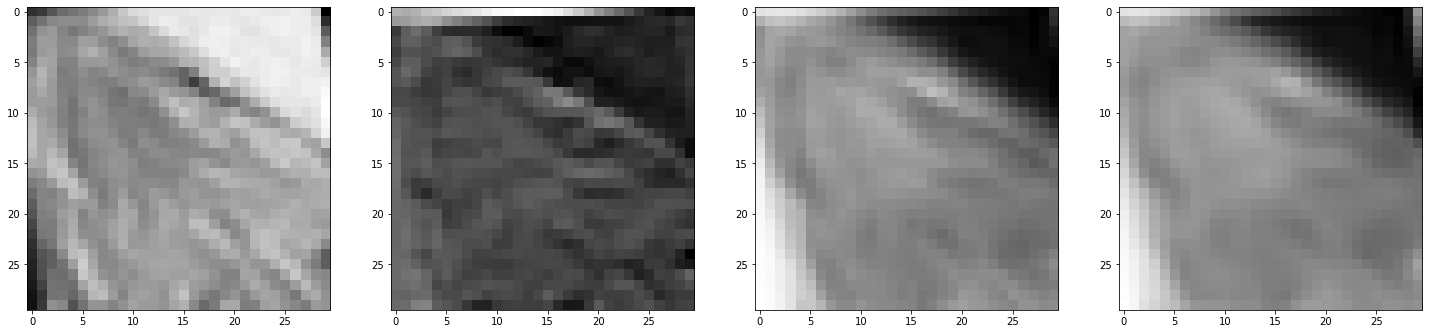

In [53]:
# pre
fig,axes = plt.subplots(1,conv1_actv.shape[1],figsize=(25,15))
for i, actv in enumerate(conv1_actv[0]):
    axes[i].imshow(actv.cpu().detach().numpy(), cmap='Greys_r')

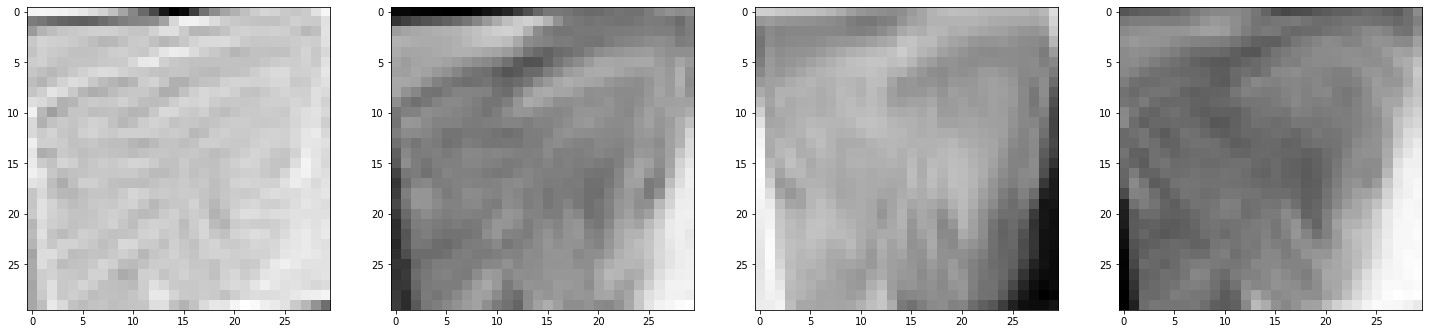

In [923]:
fig,axes = plt.subplots(1,conv1_actv.shape[1],figsize=(25,15))
for i, actv in enumerate(conv1_actv[0]):
    axes[i].imshow(actv.cpu().detach().numpy(), cmap='Greys_r')

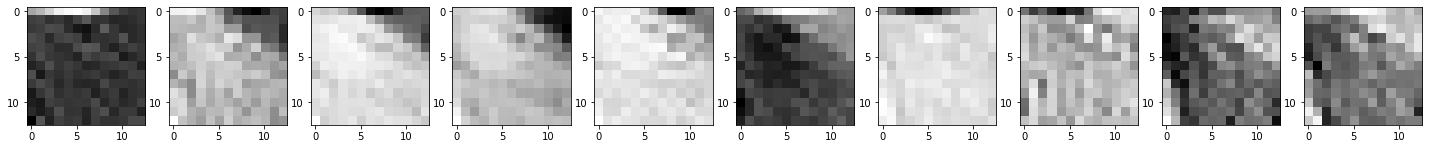

In [54]:
# pre
fig,axes = plt.subplots(1,conv2_actv.shape[1],figsize=(25,15))
for i, actv in enumerate(conv2_actv[0]):
    axes[i].imshow(actv.cpu().detach().numpy(), cmap='Greys_r')

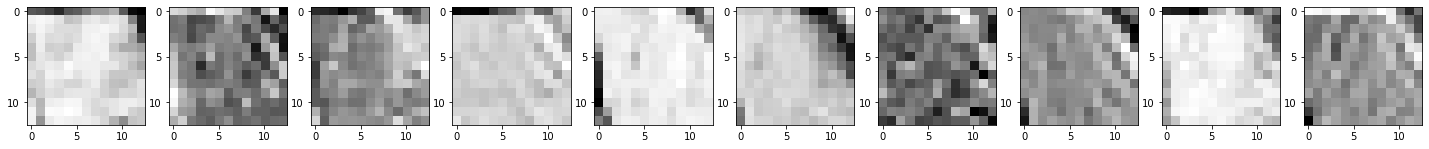

In [893]:
fig,axes = plt.subplots(1,conv2_actv.shape[1],figsize=(25,15))
for i, actv in enumerate(conv2_actv[0]):
    axes[i].imshow(actv.cpu().detach().numpy(), cmap='Greys_r')

In [55]:
# pre
net_wh.head_embedder(im_test.view(1,1,32,32).to('cuda'))

tensor([[ 0.7030, -1.7329]], device='cuda:0', grad_fn=<AddmmBackward>)

In [894]:
net_wh2.head_embedder(im_test.view(1,1,32,32).to('cuda'))

tensor([[-2.8560]], device='cuda:0', grad_fn=<AddmmBackward>)

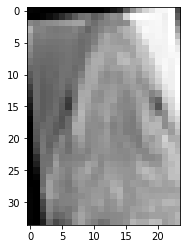

In [597]:
plt.imshow(heads2[1000], cmap='Greys_r')

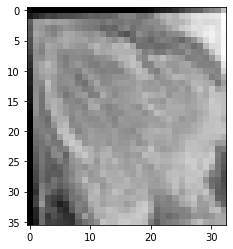

In [570]:
rot_im = rotate_image(255-im, get_rot_angle(trial_1_hom))
plt.imshow(rot_im,cmap="Greys_r")

## Metric for cumulative angle and norm displacement

In [157]:
import torch

In [236]:
# sample data
x1 = np.linspace(0, 10, 20)
y1 = np.linspace(0, 8, 20)
#x1 = np.zeros(20)

target = np.stack((x1, y1), axis=1)

x2 = np.copy(x1) * np.linspace(1, 3, 20)
y2 = np.copy(y1)
pred = np.stack((x2, y2), axis=1)

In [237]:
pred

array([[ 0.        ,  0.        ],
       [ 0.58171745,  0.42105263],
       [ 1.27423823,  0.84210526],
       [ 2.07756233,  1.26315789],
       [ 2.99168975,  1.68421053],
       [ 4.0166205 ,  2.10526316],
       [ 5.15235457,  2.52631579],
       [ 6.39889197,  2.94736842],
       [ 7.75623269,  3.36842105],
       [ 9.22437673,  3.78947368],
       [10.8033241 ,  4.21052632],
       [12.49307479,  4.63157895],
       [14.29362881,  5.05263158],
       [16.20498615,  5.47368421],
       [18.22714681,  5.89473684],
       [20.3601108 ,  6.31578947],
       [22.60387812,  6.73684211],
       [24.95844875,  7.15789474],
       [27.42382271,  7.57894737],
       [30.        ,  8.        ]])

In [238]:
def angle_norm_displacement(target, pred):
    if len(pred.shape) == 2:
        pred = pred.unsqueeze(0)
        target = target.unsqueeze(0)
    
    target_diffs = target[:, 1:] - target[:, :-1]
    pred_diffs = pred[:, 1:] - pred[:, :-1]
    target_angle = torch.atan(target_diffs[:, :, 1] / target_diffs[:, :, 0])
    pred_angle = torch.atan(pred_diffs[:, :, 1] / pred_diffs[:, :, 0])

    target_angle_diffs = target_angle[:, 1:] - target_angle[:, :-1]
    pred_angle_diffs = pred_angle[:, 1:] - pred_angle[:, :-1]
    total_angle_displacement = (target_angle_diffs - pred_angle_diffs).sum(1)
    
    target_norms = torch.norm(target_diffs, dim=2)
    pred_norms = torch.norm(pred_diffs, dim=2)
    total_norm_displacement = (target_norms - pred_norms).sum(1)
    
    return (torch.abs(total_norm_displacement).mean(),
            torch.abs(total_angle_displacement).mean())

In [239]:
tt = torch.stack([torch.tensor(target)]*2)
tp = torch.stack([torch.tensor(pred)]*2)

e = torch.normal(torch.zeros(tt.size()), 0.5*torch.ones(tp.size()))
tp = tt + e
angle_norm_displacement(tt, tp)

(tensor(8.0282, dtype=torch.float64), tensor(1.4967, dtype=torch.float64))

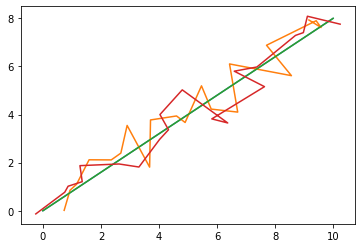

In [240]:
for i in range(tt.size(0)):
    plt.plot(tt[i, :, 0], tt[i, :, 1])
    plt.plot(tp[i, :, 0], tp[i, :, 1])